# Kaggle Competition: Advanced Regression Techniques
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
## Outline
1. Basic Exploration and EDA
2. Feature Engineering
5. Modelling
6. Submission

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utility import h1_correlation, rmsle
from scipy import stats
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, RobustScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import r2_score
import xgboost as xgb
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv',index_col = 'Id')
df_test = pd.read_csv('test.csv',index_col = 'Id')
conserve_test_ids = df_train.shape[0]
df = pd.concat((df_train, df_test))

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


### Basic Exploration and EDA

In [3]:
# Show dataframe attributes
df.shape

(2919, 80)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


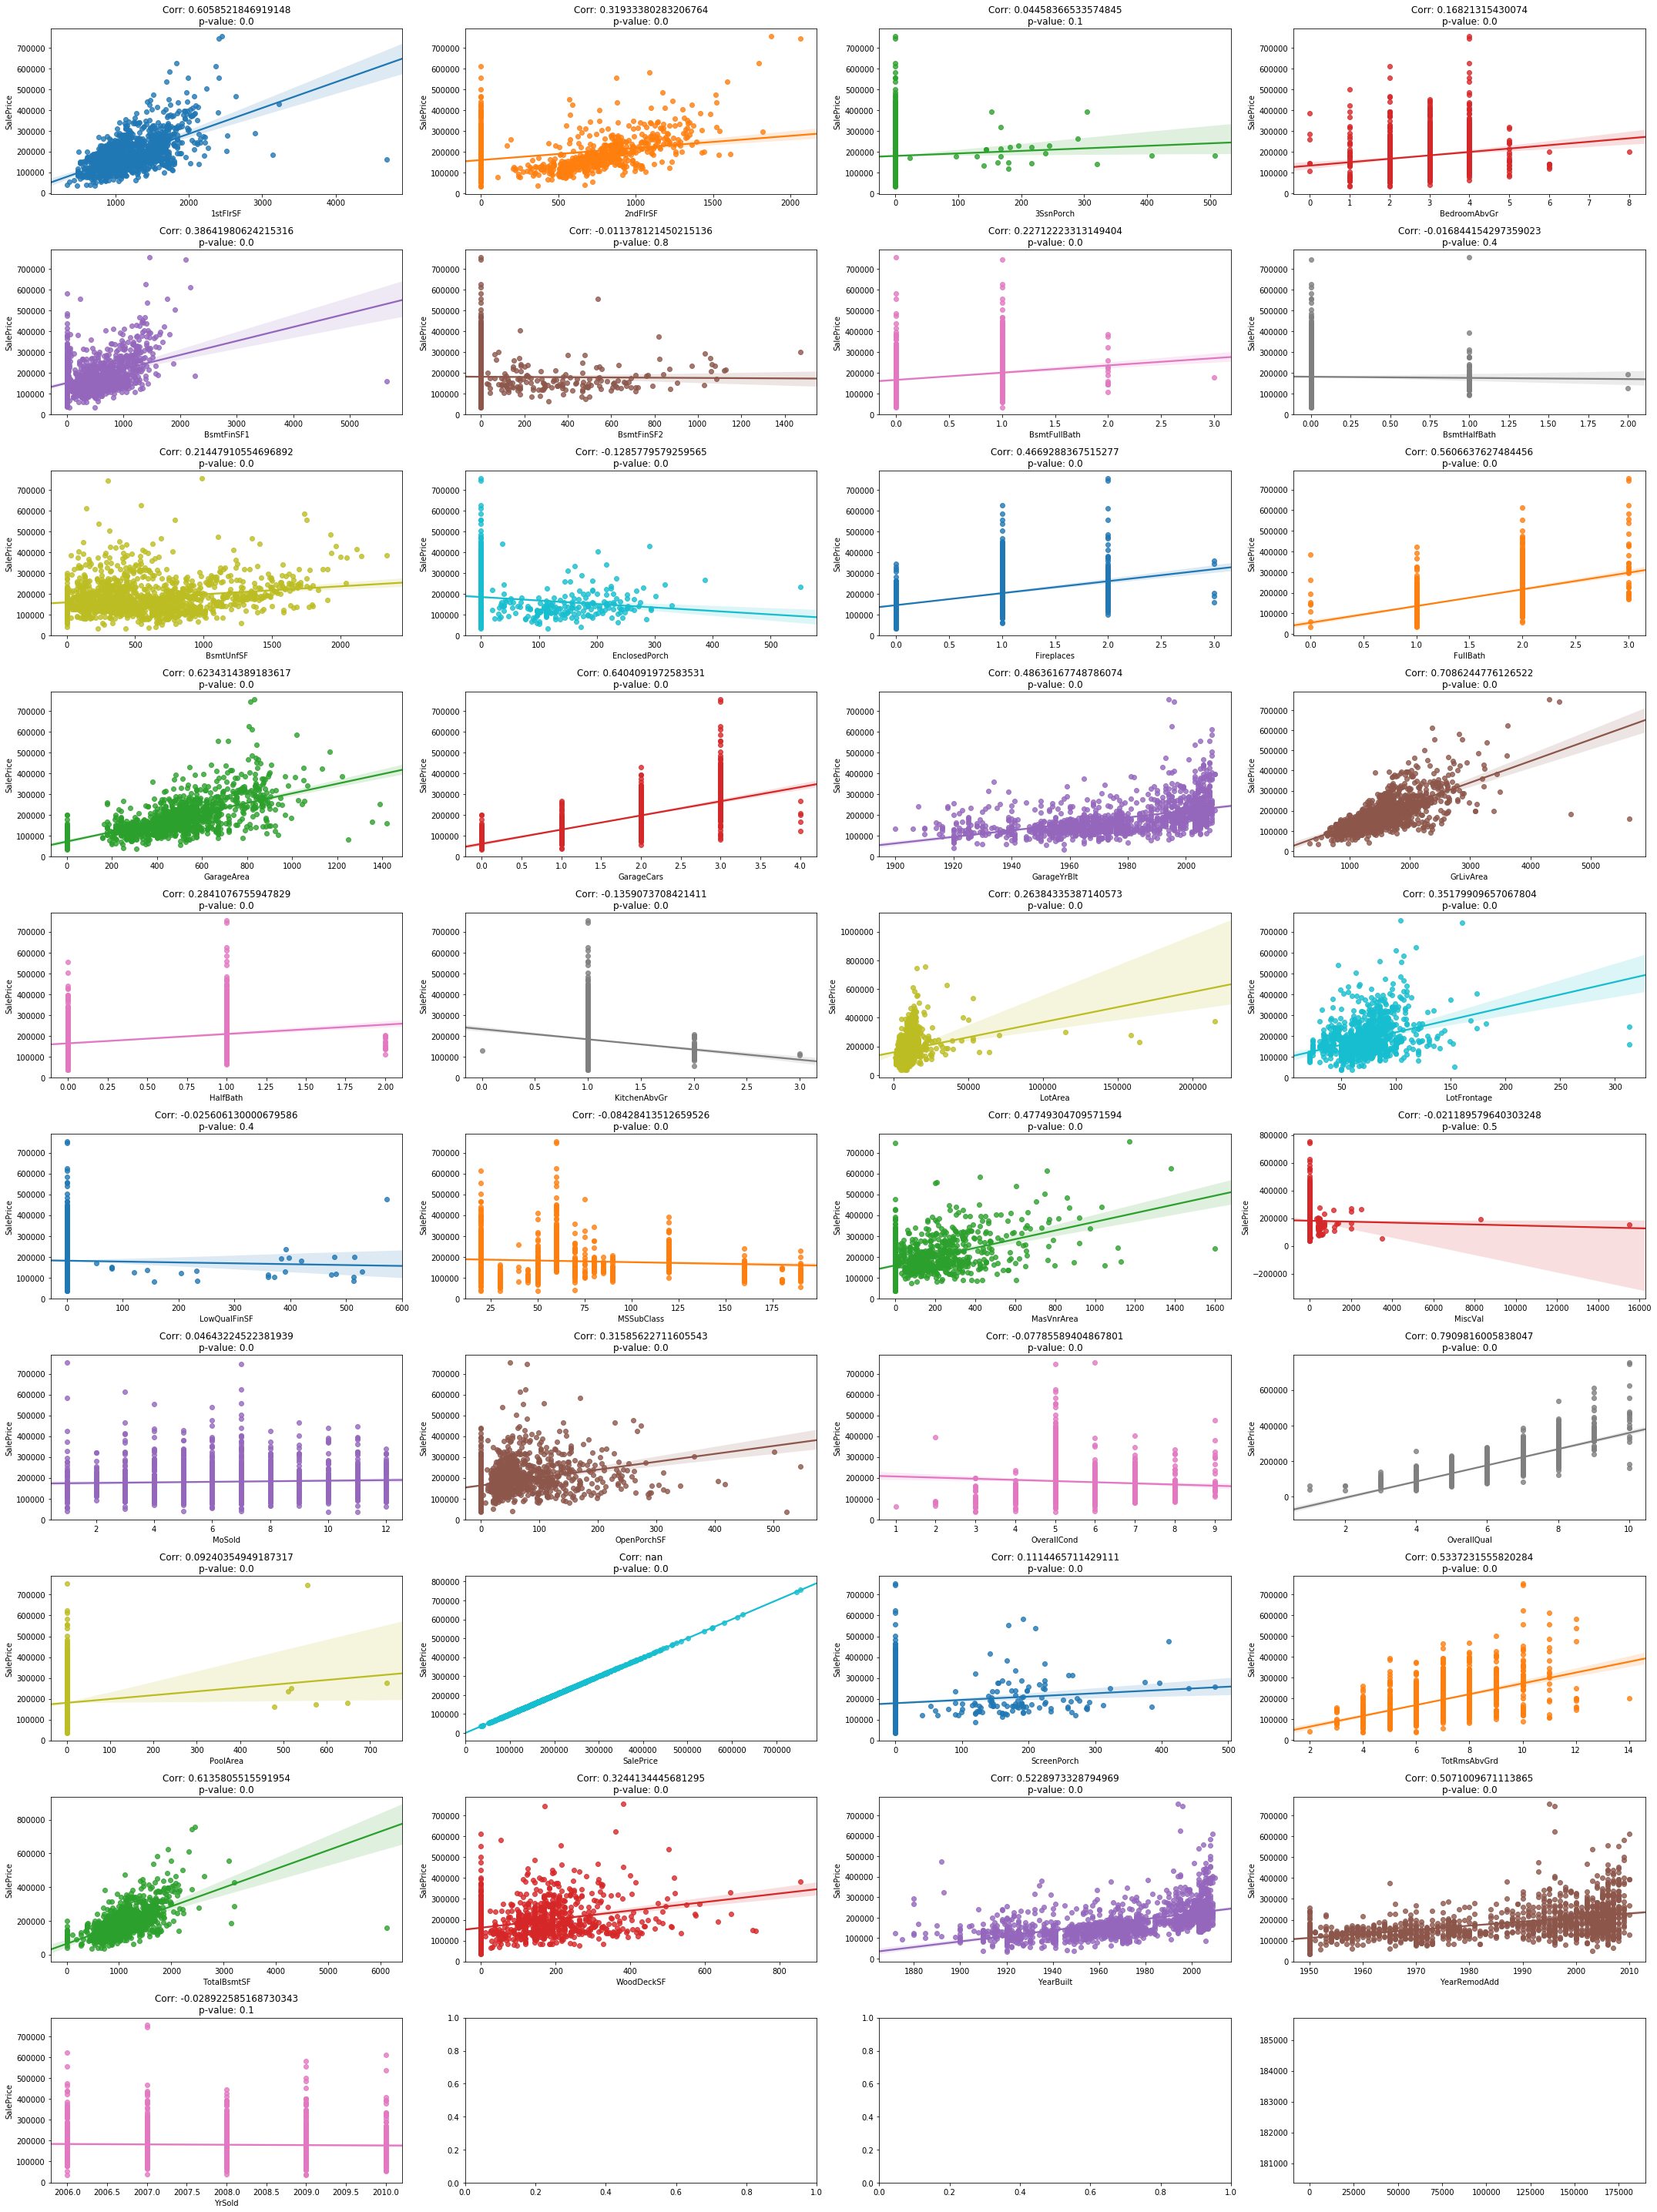

In [5]:
# Examination of numerical variables (correlation to target)
num_features = [feature for feature in df.columns if df[feature].dtype!= 'object']

cols = 4
rows = 10

fig, ax = plt.subplots(rows,cols,figsize=(rows*3,cols*10))
i=0

for row in range(rows):
    for col in range(cols):
        if i<len(num_features):
            corr, p_val = h1_correlation(df,num_features[i],'SalePrice',permutations=1*10**1)
            sns.regplot(x=num_features[i],y='SalePrice',data=df,order=1,ax=ax[row][col]).set_title('Corr: {}\np-value: {}'.format(corr,p_val))
            i+=1
            
plt.tight_layout()
plt.show()

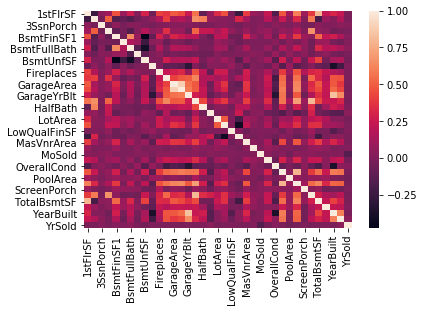

In [6]:
# Examination of non-numerical features (correlation matrix)

sns.heatmap(df.corr())

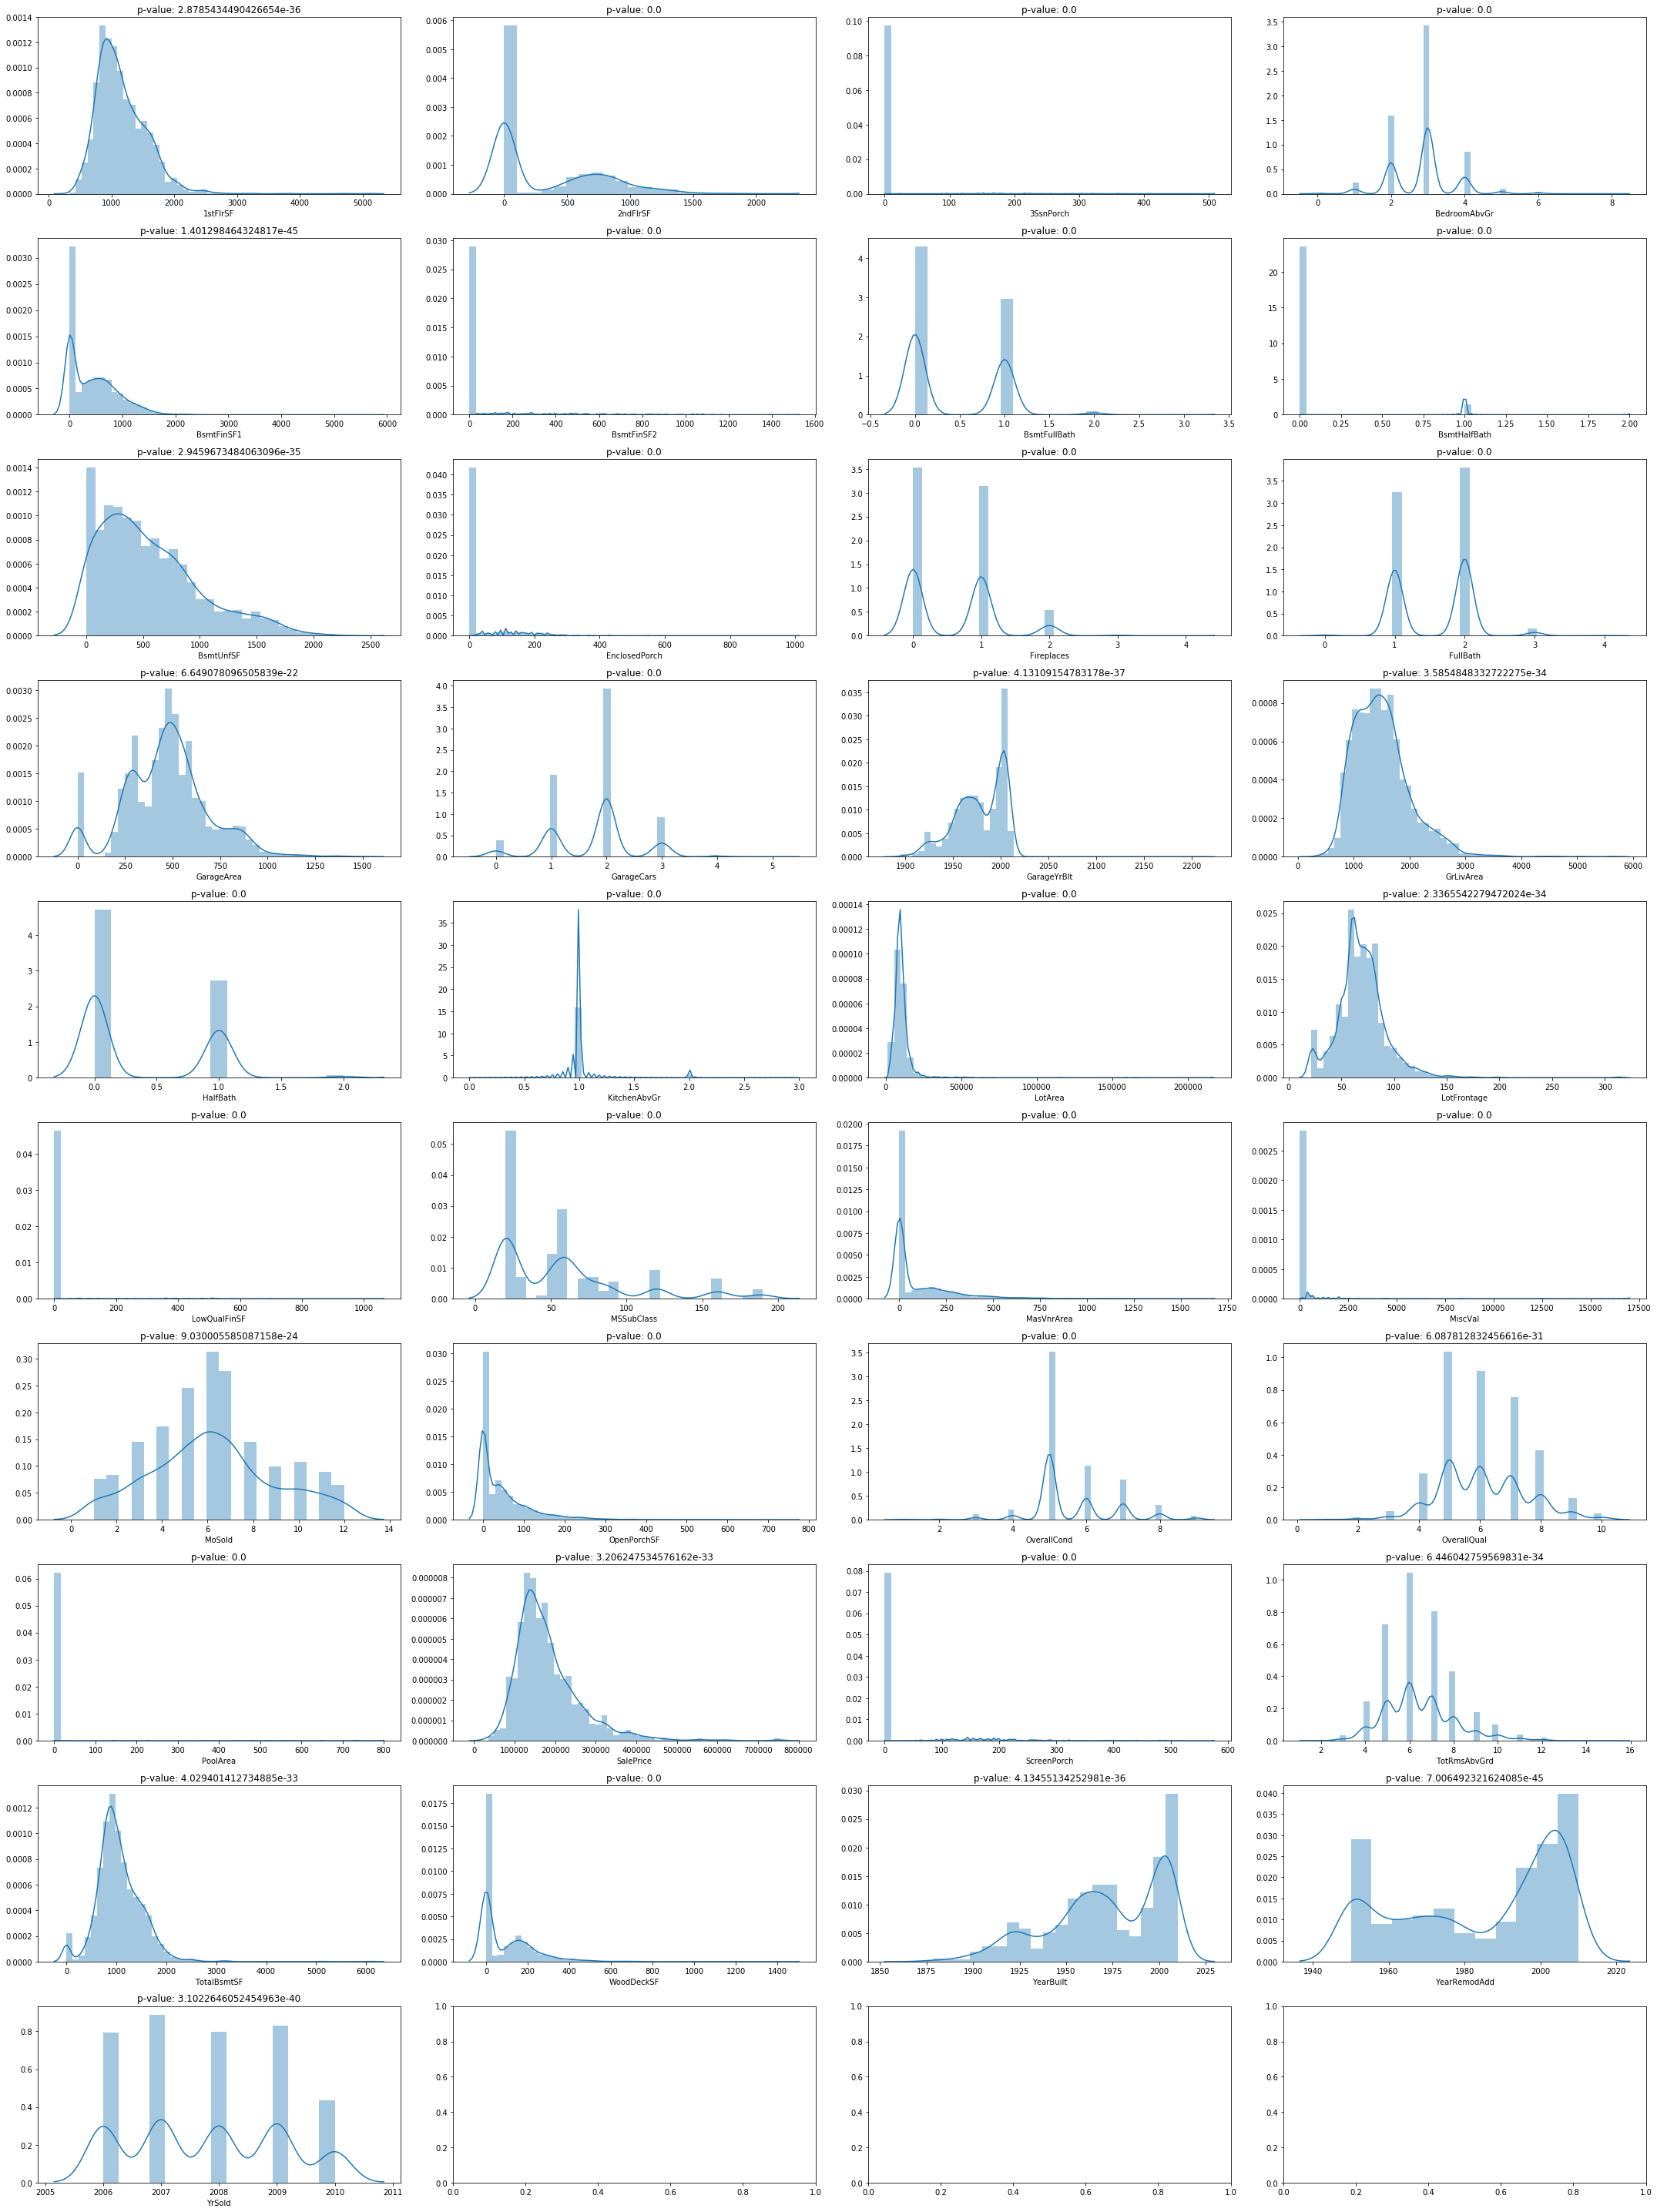

In [7]:
# Examination of numerical features (distributions)
cols = 4
rows = 10

fig, ax = plt.subplots(rows,cols,figsize=(rows*3,cols*10))
i=0

for row in range(rows):
    for col in range(cols):
        if i<len(num_features):
            sns.distplot(df[num_features[i]].dropna(),ax = ax[row][col]).set_title('p-value: {}'.format(stats.shapiro(df[num_features[i]].dropna())[1]))
            i+=1
            
plt.tight_layout()
plt.show()

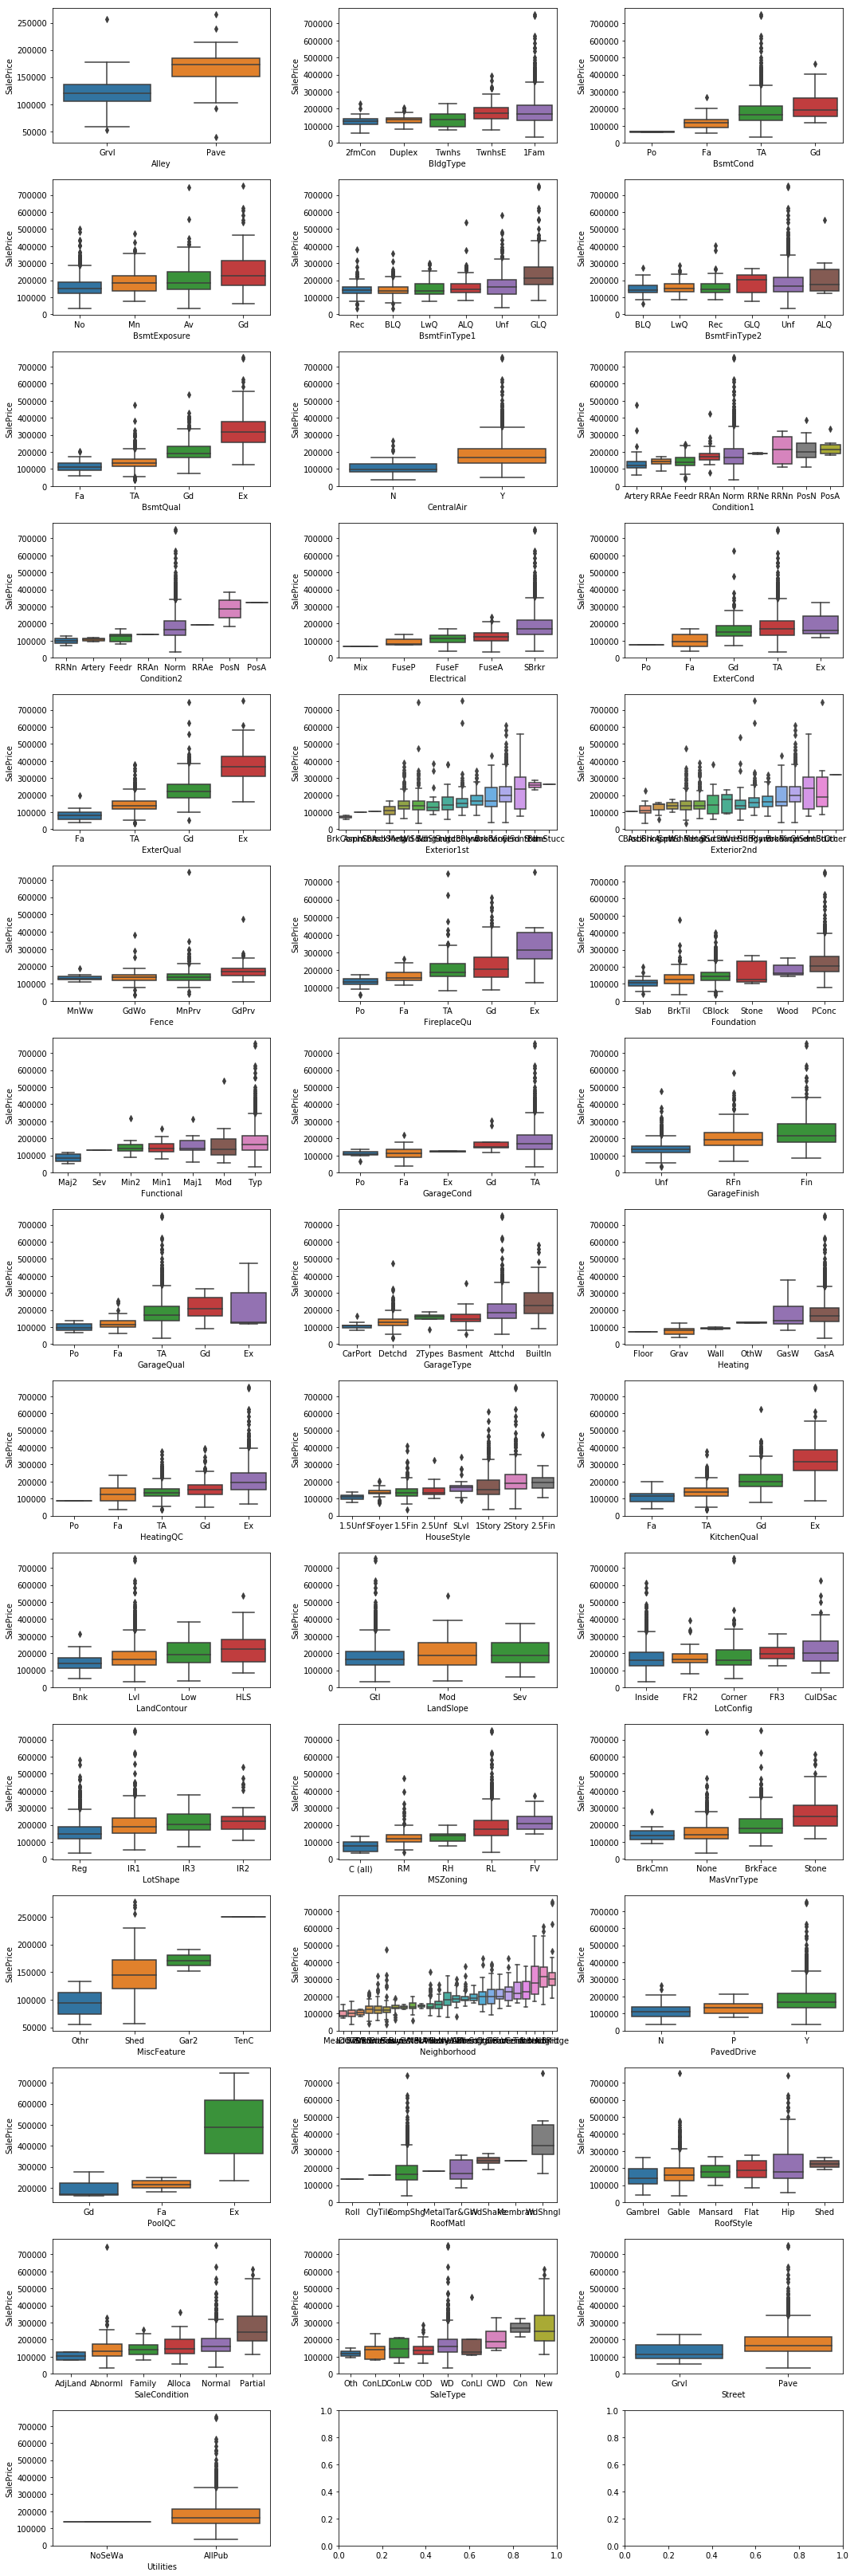

In [8]:
# Examination of non-numerical features
non_numerical_features = [feature for feature in df.columns if feature not in num_features]

cols = 3
rows = 15

fig,ax = plt.subplots(rows,cols,figsize=(cols*5,rows*3))
i = 0

for row in range(rows):
    for col in range(cols):
        if i<len(non_numerical_features):
            cat_means = df.groupby(non_numerical_features[i])[[non_numerical_features[i],'SalePrice']].mean()
            target_cats = cat_means.index.tolist()
            target_means = list(cat_means.iloc[:,0])
            ordered_list = sorted(zip(target_means,target_cats),key=lambda x: x[0])
            order = np.array([y for x,y in ordered_list])
            sns.boxplot(x=non_numerical_features[i],y='SalePrice',data=df,order=order,ax=ax[row][col])
            i+=1
            
plt.tight_layout()

plt.show()

In [9]:
# Examination of missing data
missing_report = pd.DataFrame(df.isnull().sum().sort_values(ascending=False),columns=['missing_values'])
missing_report['missing_values_rel'] = missing_report['missing_values']/df.shape[0]
        
for index,value in missing_report.iterrows():
    if value[0]==0:
        missing_report.drop(index,inplace=True)
        
missing_report

,missing_values,missing_values_rel
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


The previous evaluation has shown that:
- There are some numerical features, that should be encoded as non-numerical features.
- Most features are far from normally distributed.Those distributions will have to be shifted.
- Missing values have to be imputed.
- There is some multicollinearity in amongst the features in the dataset.

### Feature Engineering

In [10]:
## Imputation of missing values
# PoolQC: NA means no pool, therefore None is imputed as its own category.
df['PoolQC'] = df['PoolQC'].fillna('None')

# MiscFeature: NA means, that there is no specific additional feature. Therefore None is imputed as its own category.
df['MiscFeature'] = df['MiscFeature'].fillna('None')

# Alley: NA means no alley access
df['Alley'] = df['Alley'].fillna('None')

# Fence: NA means no fence
df['Fence'] = df['Fence'].fillna('None')

# FireplaceQu: NA means no fireplace
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

# GarageType: NA means no garage (garage features are treated accordingly)
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

# BsmtFinType2: NA means no basement (related features are treated accordingly)
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')

# MasVnrArea: Object can have no veneer area
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

# MasVnrType: See above
df['MasVnrType'] = df['MasVnrType'].fillna('None')

# Electrical: As the most frequent value by far is SBrkr, and only one single value is affected, SBkrkr can be imputed.
df['Electrical'] = df['Electrical'].fillna('SBrkr')

# MSZoning: Assign Mode of data set to missing values
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
assert df['MSZoning'].isnull().sum()==0

# Utilities: The overwhelming majority of train observations are 'AllPub', therefore, that value is imputed
df['Utilities'] = df['Utilities'].fillna('AllPub')

# Functional: Similar to utilities but less pronounced → under the assumption, that there is no systematic reason for a certain value to
# be missing, the mode is the best option again
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])

# Exterior2nd: See 'Functional'
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

# SaleType: See 'Functional'
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

# Exterior1st: See 'Functional'
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])

# KitchenQual: See 'Functional'
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

# GarageCars: Similar to other Garage related features
df['GarageCars'] = df['GarageCars'].fillna(0)

# GarageArea: Similar to other Garage related features
df['GarageArea'] = df['GarageArea'].fillna(0)

# Bsmt Features: Similar consideration as in Training set (np.nan = no Basement so np.nan → None)
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)

# LotFrontage: Missing values must be imputed; as there is no other obvious way, the value can be imputed by linear regression
tsvd = TruncatedSVD(n_components=10)
imputation_pipeline = Pipeline([('encoder',OneHotEncoder(handle_unknown='ignore')),
                               ('tsvd',tsvd),
                               ('linreg',LinearRegression())])

X_imp_train = df.loc[df['LotFrontage'].notnull()].drop(['SalePrice','LotFrontage'],axis=1)
y_imp_train = df.loc[:,'LotFrontage'].dropna()
X_imp = df.loc[df['LotFrontage'].isnull()].drop(['SalePrice','LotFrontage'],axis=1)

imputation_pipeline.fit(X_imp_train,y_imp_train)
imp_values = imputation_pipeline.predict(X_imp)

index_list = df.loc[df['LotFrontage'].isnull()].index.tolist()
imp_Series = pd.Series(imp_values,index=index_list)
df['LotFrontage'] = df['LotFrontage'].fillna(imp_Series)

assert df.drop('SalePrice',axis=1).isnull().sum().sum() == 0

In [11]:
#Add information: Houses with same YearRemodAdd and YearBuilt have no Remod Added

df.loc[df['YearRemodAdd']==df['YearBuilt'],'YearRemodAdd'] = 'None'

In [12]:
# Converting numerical features to objects: Nominal features
to_be_converted = ['MoSold','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt','MSSubClass']

for feature in to_be_converted:
    df[feature].astype(object)

In [13]:
# Convert numerical features to objects/categories: Ordinal Features
to_be_converted_ordinal = ['MSZoning','Alley','MasVnrType','ExterQual','FireplaceQu','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
                           'GarageQual','GarageCond','PoolQC','Utilities','BldgType','OverallQual','OverallCond','ExterCond','BsmtExposure',
                           'BsmtFinType1','BsmtFinType2','Functional','GarageFinish','PavedDrive','Fence']

for feature in to_be_converted_ordinal:
    le = LabelEncoder()
    encoded_feature = le.fit_transform(df[feature])
    df[feature] = encoded_feature

In [14]:
# Shift numerical features' distribution towards normal distribution by running a boxcox transformation over all remaining numerical features
# For easier interpretability, use simple log transformation for target variable 

num_features = [feature for feature in df.columns if df[feature].dtype != 'object']
for feature in num_features:
    if feature != 'SalePrice':
        transform_data = df[feature].loc[df[feature]>0]
        lm = 0.15
        transform_result = stats.boxcox(transform_data,lm)
        transform_impose = np.empty_like(df[feature])
        transform_impose[df[feature] > 0] = transform_result
        transform_impose[df[feature]<= 0] = df[feature].loc[df[feature]<=0]
        df[feature] = transform_impose
    else:
        df[feature] = df[feature].transform(lambda x: np.log(x))

In [15]:
# Get dummies from dataset
df_processed = pd.get_dummies(df)

In [16]:
# Data Wrangling is concluded
train_processed = df_processed.loc[df_processed['SalePrice'].notnull()]
test_processed = df_processed.loc[df_processed['SalePrice'].isnull()]
assert train_processed.isnull().sum().sum() == 0
assert test_processed.isnull().sum().sum() == test_processed.shape[0]
assert train_processed.shape[1] == test_processed.shape[1]
assert test_processed.shape[0] == df_test.shape[0]
train_processed.to_csv('train_processed.csv',index_label='Id')
test_processed.drop('SalePrice',axis=1).to_csv('test_processed.csv',index_label='Id')

## Modelling

In [17]:
# Load processed training data
train_data = pd.read_csv('train_processed.csv',index_col='Id')

In [18]:
# Prepare the data
X = train_data.drop('SalePrice',axis=1)
y_train = np.array(train_data.loc[:,'SalePrice'])

In [19]:
# Data preparation
preparation_pipeline = make_pipeline(StandardScaler())
print(X.shape)
X_train = preparation_pipeline.fit_transform(X)

(1460, 273)


C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
# Prepare KFold validation function
def rmsle_cv(model):
    kf = KFold(3,shuffle=True,random_state=42).get_n_splits(X_train)
    rmse = np.sqrt(-cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=kf))
    return rmse

In [21]:
# Define model test function
# TODO: Implement GridSearchCV or RandomizedGridSearchCV
def model_testing(model):
    rmsle_train_score = rmsle_cv(model)
    model.fit(X_train,y_train)
    
    return rmsle_train_score

In [22]:
# Train Base Models
lin_reg = LinearRegression()
rand_for = RandomForestRegressor()
sup_vec_reg = SVR()
ada_boost = AdaBoostRegressor()
grad_boost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)
xgboost_reg = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                               learning_rate=0.05, max_depth=3, 
                               min_child_weight=1.7817, n_estimators=2200,
                               reg_alpha=0.4640, reg_lambda=0.8571,
                               subsample=0.5213, silent=1,
                               random_state =7, nthread = -1)

models= [lin_reg,rand_for,sup_vec_reg,ada_boost,grad_boost,xgboost_reg]
names = ['LR','RF','SVR','ABR','GBR','XGB-Test']

train_results = list(map(model_testing,models))

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

In [23]:
# Training Results
rmsle_train_scores = [train_results[i] for i in range(len(train_results))]

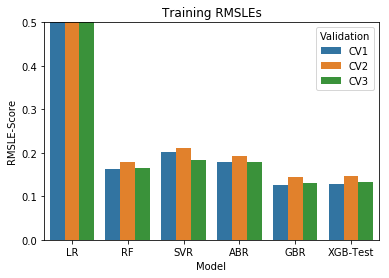

            CV1           CV2           CV3     Model
0  4.822735e+12  1.145681e+12  4.705142e+12        LR
1  1.628904e-01  1.791713e-01  1.654528e-01        RF
2  2.027278e-01  2.100570e-01  1.828635e-01       SVR
3  1.779724e-01  1.917669e-01  1.792611e-01       ABR
4  1.262178e-01  1.441896e-01  1.301842e-01       GBR
5  1.287675e-01  1.471164e-01  1.320074e-01  XGB-Test


In [24]:
# Plotting Training Results
train_results_df = pd.DataFrame(rmsle_train_scores,columns=['CV'+str(i+1) for i in range(rmsle_train_scores[0].shape[0])])
train_results_df['Model'] = names
train_results_df1 = train_results_df.melt(id_vars='Model',var_name='Validation',value_name='RMSLE-Score')
sns.barplot(x='Model',y='RMSLE-Score',data=train_results_df1,hue='Validation').set_title('Training RMSLEs')
plt.ylim(0,0.5)

plt.show()
print(train_results_df)

In [25]:
# Train a UL model on the data (for testing purposes of the meta model)
# Model: Gaussian Mixture Model, testing for optimal k
from sklearn.mixture import GaussianMixture

In [26]:
# Define Testing function
def gmm_test(data,max_components):
    total_score = []
    test_components = []
    for i in range(max_components):
        model = GaussianMixture(n_components=i+1)
        labels = model.fit_predict(data)
        score = model.aic(data)
        total_score.append(score)
        test_components.append(i+1)
    sns.lineplot(x=test_components,y=total_score)
    plt.xticks(list(range(1,31)))
    plt.show()

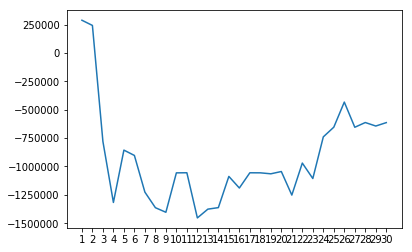

In [27]:
# Testing for the optimal model
gmm_test(X_train,30)

In [28]:
# It appears, that the optimal model, according to the AIC, is one with n_components = 22
gm_model = GaussianMixture(n_components = 22)
label_predictions = gm_model.fit_predict(X_train)
if gm_model not in models:
    models.append(gm_model)

In [29]:
# Combine predictions and labels
lin_reg_pred = lin_reg.predict(X_train)
rand_for_pred = rand_for.predict(X_train)
sup_vec_reg_pred = sup_vec_reg.predict(X_train)
ada_boost_pred = ada_boost.predict(X_train)
grad_boost_pred = grad_boost.predict(X_train)
xgboost_reg_pred = xgboost_reg.predict(X_train)

meta_data_train = np.column_stack((lin_reg_pred,rand_for_pred,sup_vec_reg_pred,ada_boost_pred,grad_boost_pred,xgboost_reg_pred,label_predictions))

In [30]:
# Train Meta model (keras DLN)
from keras.models import Sequential
from keras.layers import Dropout, Dense, LeakyReLU

meta_model_dnn = Sequential()
meta_model_dnn.add(Dense(256,kernel_initializer='normal',input_dim=meta_data_train.shape[1]))
meta_model_dnn.add(Dropout(rate=0.2))
meta_model_dnn.add(LeakyReLU())

for i in range(100):
    meta_model_dnn.add(Dense(128,kernel_initializer='normal'))
    meta_model_dnn.add(Dropout(rate=0.2))
    meta_model_dnn.add(LeakyReLU())

meta_model_dnn.add(Dense(1,kernel_initializer='normal',activation='linear'))

meta_model_dnn.compile(optimizer='SGD',loss='mean_squared_error',metrics=['mean_squared_error'])

meta_model_dnn.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
leaky_re_lu_2 (LeakyR

In [31]:
# Train Meta Model
meta_model_dnn.fit(meta_data_train,y_train,epochs=500,batch_size=32,shuffle=True,validation_split=0.1,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1314 samples, validate on 146 samples
Epoch 1/500
1314/1314 [==============================] - 17s 13ms/step - loss: 32.2828 - mean_squared_error: 32.2828 - val_loss: 1.6769 - val_mean_squared_error: 1.6769
Epoch 2/500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2033 - mean_squared_error: 1.2033 - val_loss: 0.5793 - val_mean_squared_error: 0.5793
Epoch 3/500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.9710 - mean_squared_error: 0.9710 - val_loss: 0.6002 - val_mean_squared_error: 0.6002
Epoch 4/500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.8218 - mean_squared_error: 0.8218 - val_loss: 0.6092 - val_mean_squared_error: 0.6092
Epoch 5/500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.8223 - mean_squared_error: 0.8223 - val_loss: 0.4924 - val_mean_squared_error: 0.4924
Epoch 6/500
1314/1314 [==============================] - 2s 1ms/step - loss:

In [32]:
# Evaluate Meta Model
yhat = meta_model_dnn.predict(meta_data_train)
meta_training_score = rmsle(y_train,yhat,exponential_transformation=True)
print('Meta-Model Training Score: {}'.format(meta_training_score))

Meta-Model Training Score: 0.40085972842241774


In [33]:
# As the simple Keras model did not perform as hoped, let's use a simple XGBRegressor model
xgb_meta = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            learning_rate=0.05, max_depth=3, 
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213, silent=1,
                            random_state =7, nthread = -1)

xgb_meta.fit(meta_data_train,y_train)
test_prediction = xgb_meta.predict(meta_data_train)

print('XGBR Meta Model Score: {}'.format(rmsle(y_train,test_prediction,exponential_transformation=True)))

XGBR Meta Model Score: 0.05060063591323374


### Submission

In [34]:
# Although the final Meta model returned the best accuracy, let's try and submit the results from all models!
submission_df = pd.read_csv('test_processed.csv',index_col='Id')
submission_index = submission_df.index.to_list()

In [35]:
# Prepare test_data
submission_pipeline = make_pipeline(StandardScaler())
X_test = submission_pipeline.fit_transform(submission_df)

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [36]:
# Create Predictions for submission
def create_submissions(models,meta_model,test_data):
    meta_data = np.empty((test_data.shape[0],len(models)))
    result_dict = {}
    for i,model in enumerate(models):
        yhat = np.exp(model.predict(test_data))
        yhat_meta = model.predict(test_data)
        meta_data[:,i] = yhat_meta
        result_dict[type(model).__name__] = yhat
    else:
        meta_predictions = np.exp(meta_model.predict(meta_data))
        result_dict['MetaModel'] = meta_predictions
    
    for key,value in result_dict.items():
        if key != 'GaussianMixture':
            export = pd.DataFrame(value,columns=['SalePrice'])
            export.index = submission_index
            export.index.name='Id'            
            export.to_csv(key+'.csv')

In [37]:
# Export Predictions
assert X_train.shape[1] == X_test.shape[1] and X_test.shape[0] == df_test.shape[0]

meta_data = create_submissions(models,xgb_meta,X_test)